## Example 2: Sensitivity analysis on a NetLogo model with SALib

This notebook provides a more advanced example of interaction between NetLogo and a Python environment, using the SALib library (Herman & Usher, 2017; available through the pip package manager) to sample and analyze a suitable experimental design for a Sobol global sensitivity analysis. All files used in the example are available from the pyNetLogo repository at https://github.com/quaquel/pyNetLogo.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyNetLogo

# Import the sampling and analysis modules for a Sobol variance-based sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

SALib relies on a problem definition dictionary which contains the number of input parameters to sample, their names (which should here correspond to a NetLogo global variable), and the sampling bounds. Documentation for SALib can be found at https://salib.readthedocs.io/en/latest/.

In [2]:
problem = {
    "num_vars": 6,
    "names": [
        "random-seed",
        "grass-regrowth-time",
        "sheep-gain-from-food",
        "wolf-gain-from-food",
        "sheep-reproduce",
        "wolf-reproduce",
    ],
    "bounds": [
        [1, 100000],
        [20.0, 40.0],
        [2.0, 8.0],
        [16.0, 32.0],
        [2.0, 8.0],
        [2.0, 8.0],
    ],
}

We start by instantiating the wolf-sheep predation example model, specifying the _gui=False_ flag to run in headless mode.

In [3]:
import os

netlogo = pyNetLogo.NetLogoLink(gui=False)
model_file = os.path.join(
    netlogo.netlogo_home, "models/Sample Models/Biology/Wolf Sheep Predation.nlogo"
)
netlogo.load_model(model_file)

The SALib sampler will automatically generate an appropriate number of samples for Sobol analysis. To calculate first-order, second-order and total sensitivity indices, this gives a sample size of _n*(2p+2)_, where _p_ is the number of input parameters, and _n_ is a baseline sample size which should be large enough to stabilize the estimation of the indices. For this example, we use _n_ = 1000, for a total of 14000 experiments.

For more complex analyses, parallelizing the experiments can significantly improve performance. An additional notebook in the pyNetLogo repository demonstrates the use of the ipyparallel library; parallel processing for NetLogo models is also supported by the Exploratory Modeling Workbench (Kwakkel, 2017).

In [4]:
n = 1000
param_values = saltelli.sample(problem, n, calc_second_order=True)

/Users/jhkwakkel/opt/anaconda3/lib/python3.8/site-packages/SALib/sample/saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)


The sampler generates an input array of shape (_n*(2p+2)_, _p_) with rows for each experiment and columns for each input parameter.

In [5]:
param_values.shape

(14000, 6)

Assuming we are interested in the mean number of sheep and wolf agents over a timeframe of 100 ticks, we first create an empty dataframe to store the results.

In [6]:
results = pd.DataFrame(columns=["Avg. sheep", "Avg. wolves"])

We then simulate the model over the 14000 experiments, reading input parameters from the param_values array generated by SALib. The repeat_report command is used to track the outcomes of interest over time. 

To later compare performance with the ipyparallel implementation of the analysis, we also keep track of the elapsed runtime.

In [7]:
import time

t0 = time.time()

for run in range(param_values.shape[0]):

    # Set the input parameters
    for i, name in enumerate(problem["names"]):
        if name == "random-seed":
            # The NetLogo random seed requires a different syntax
            netlogo.command("random-seed {}".format(param_values[run, i]))
        else:
            # Otherwise, assume the input parameters are global variables
            netlogo.command("set {0} {1}".format(name, param_values[run, i]))

    netlogo.command("setup")
    # Run for 100 ticks and return the number of sheep and wolf agents at each time step
    counts = netlogo.repeat_report(["count sheep", "count wolves"], 100, include_t0=False)

    # For each run, save the mean value of the agent counts over time
    results.loc[run, "Avg. sheep"] = counts["count sheep"].values.mean()
    results.loc[run, "Avg. wolves"] = counts["count wolves"].values.mean()

elapsed = time.time() - t0  # Elapsed runtime in seconds

In [8]:
elapsed

1114.0971550941467

The "to_csv" dataframe method provides a simple way of saving the results to disk.

Pandas supports several more advanced storage options, such as serialization with msgpack, or hierarchical HDF5 storage.

In [9]:
results.to_csv("Sobol_sequential.csv")

In [10]:
results = pd.read_csv("Sobol_sequential.csv", header=0, index_col=0)

In [11]:
results.head(5)

,Avg. sheep,Avg. wolves
0,179.18,205.11
1,234.55,269.35
2,179.18,205.11
3,179.18,205.11
4,151.18,219.93


We can then proceed with the analysis, first using a histogram to visualize output distributions for each outcome:

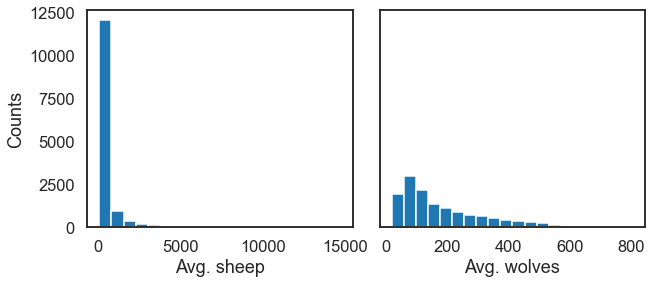

In [12]:
sns.set_style("white")
sns.set_context("talk")
fig, ax = plt.subplots(1, len(results.columns), sharey=True)

for i, n in enumerate(results.columns):
    ax[i].hist(results[n], 20)
    ax[i].set_xlabel(n)

ax[0].set_ylabel("Counts")

fig.set_size_inches(10, 4)
fig.subplots_adjust(wspace=0.1)
# plt.savefig('JASSS figures/SA - Output distribution.pdf', bbox_inches='tight')
# plt.savefig('JASSS figures/SA - Output distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Bivariate scatter plots can be useful to visualize relationships between each input parameter and the outputs. Taking the outcome for the average sheep count as an example, we obtain the following, using the scipy library to calculate the Pearson correlation coefficient (r) for each parameter:

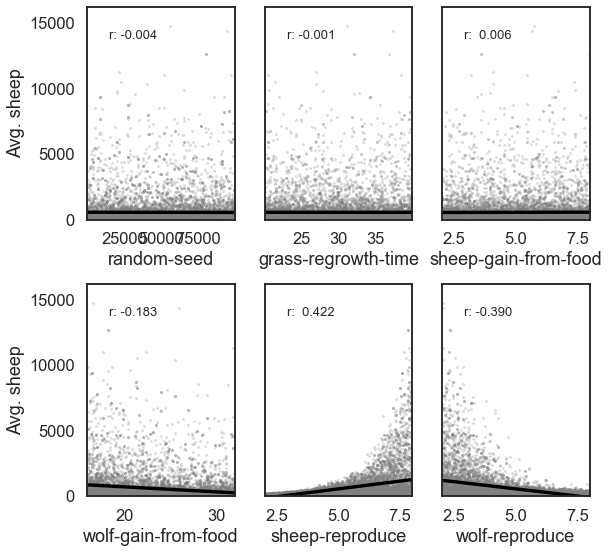

In [15]:
%matplotlib inline
import scipy

nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, sharey=True)
sns.set_context("talk")
y = results["Avg. sheep"]

for i, a in enumerate(ax.flatten()):
    x = param_values[:, i]
    sns.regplot(
        x=x,
        y=y,
        ax=a,
        ci=None,
        color="k",
        scatter_kws={"alpha": 0.2, "s": 4, "color": "gray"},
    )
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate(
        "r: {:6.3f}".format(pearson[0]),
        xy=(0.15, 0.85),
        xycoords="axes fraction",
        fontsize=13,
    )
    if divmod(i, ncol)[1] > 0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(problem["names"][i])
    a.set_ylim([0, 1.1 * np.max(y)])

fig.set_size_inches(9, 9, forward=True)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
# plt.savefig('JASSS figures/SA - Scatter.pdf', bbox_inches='tight')
# plt.savefig('JASSS figures/SA - Scatter.png', dpi=300, bbox_inches='tight')
plt.show()

This indicates a positive relationship between the "sheep-gain-from-food" parameter and the mean sheep count, and negative relationships for the "wolf-gain-from-food" and "wolf-reproduce" parameters.

We can then use SALib to calculate first-order (S1), second-order (S2) and total (ST) Sobol indices, to estimate each input's contribution to output variance. By default, 95% confidence intervals are estimated for each index.

In [16]:
Si = sobol.analyze(
    problem,
    results["Avg. sheep"].values,
    calc_second_order=True,
    print_to_console=False,
)

As a simple example, we first select and visualize the first-order and total indices for each input, converting the dictionary returned by SALib to a dataframe.

In [17]:
Si_filter = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(Si_filter, index=problem["names"])

In [18]:
Si_df

,ST,ST_conf,S1,S1_conf
random-seed,0.103739,0.065273,0.014167,0.032679
grass-regrowth-time,0.000000,0.000000,0.000000,0.000000
sheep-gain-from-food,0.000000,0.000000,0.000000,0.000000
wolf-gain-from-food,0.235333,0.075786,0.023840,0.038995
sheep-reproduce,0.880199,0.341478,0.256187,0.116321
wolf-reproduce,0.697098,0.214280,0.200570,0.085892


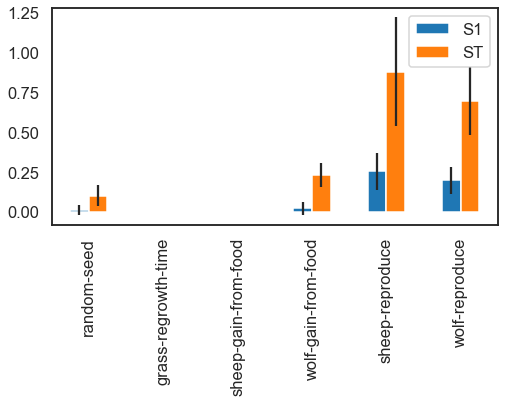

In [19]:
sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 4)

# plt.savefig('JASSS figures/SA - Indices.pdf', bbox_inches='tight')
# plt.savefig('JASSS figures/SA - Indices.png', dpi=300, bbox_inches='tight')

plt.show()

The "sheep-gain-from-food" parameter has the highest ST index, indicating that it contributes over 50% of output variance when accounting for interactions with other parameters. However, it can be noted that the confidence bounds are overly broad due to the small _n_ value used for sampling, so that a larger sample would be required for reliable results. For instance, the S1 index is estimated to be larger than ST for the "random-seed" parameter, which is an artifact of the small sample size.

We can use a more sophisticated visualization to include the second-order interactions between inputs.

<ipython-input-24-c46906c37e0d>:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names)


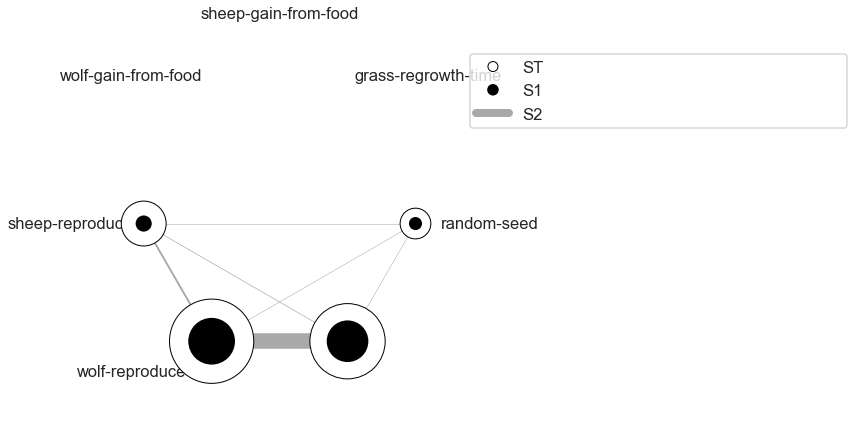

In [24]:
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw, zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc == "w":
            fill = False
        else:
            ec = "none"

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle(
            (x, y),
            radius=si,
            ec=ec,
            fc=fc,
            transform=ax.transData._b,
            zorder=zorder,
            lw=lw,
            fill=True,
        )
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ["ST", "S1", "S2"]:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten()  # flatten in case of S2
        # TODO:: remove nans

        filtered = [(name, locs[i]) for i, name in enumerate(names) if data[i] > threshold]
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ["ST_conf", "S1_conf", "S2_conf"]:
        raise NotImplementedError
    else:
        raise ValueError("unknown value for criterion")

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion="ST", threshold=0.01):
    """plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    """
    max_linewidth_s2 = 15  # 25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    # sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key: sobol_indices[key] for key in ["ST", "S1"]}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem["names"])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices["S2"], index=problem["names"], columns=problem["names"])
    s2[s2 < 0.0] = 0.0  # Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem["names"]
    n = len(names)
    ticklocs = np.linspace(0, 2 * pi, n + 1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs, criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines["polar"].set_visible(False)
    #     ax.set_xticks(ticklocs)
    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(ymax=1.4)
    legend(ax)

    # plot ST
    plot_circles(
        ax,
        filtered_locs,
        filtered_names,
        max_s_radius,
        sobol_stats["ST"],
        smax,
        smin,
        "w",
        "k",
        1,
        9,
    )

    # plot S1
    plot_circles(
        ax,
        filtered_locs,
        filtered_names,
        max_s_radius,
        sobol_stats["S1"],
        smax,
        smin,
        "k",
        "k",
        1,
        10,
    )

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5 + max_linewidth_s2 * normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1, 1], c="darkgray", lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch


class HandlerCircle(HandlerPatch):
    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


def legend(ax):
    some_identifiers = [
        plt.Circle((0, 0), radius=5, color="k", fill=False, lw=1),
        plt.Circle((0, 0), radius=5, color="k", fill=True),
        plt.Line2D([0, 0.5], [0, 0.5], lw=8, color="darkgray"),
    ]
    ax.legend(
        some_identifiers,
        ["ST", "S1", "S2"],
        loc=(1, 0.75),
        borderaxespad=0.1,
        mode="expand",
        handler_map={plt.Circle: HandlerCircle()},
    )


sns.set_style("whitegrid")
fig = plot_sobol_indices(Si, criterion="ST", threshold=0.005)
fig.set_size_inches(7, 7)
# plt.savefig('JASSS figures/Figure 8 - Interactions.pdf', bbox_inches='tight')
# plt.savefig('JASSS figures/Figure 8 - Interactions.png', dpi=300, bbox_inches='tight')
plt.show()

In this case, the sheep-gain-from-food variable has strong interactions with the wolf-gain-from-food and sheep-reproduce inputs in particular. The size of the ST and S1 circles correspond to the normalized variable importances.

Finally, the kill_workspace() function shuts down the NetLogo instance.

In [25]:
netlogo.kill_workspace()